## 🧠 SensorGuard - Failure Prediction Modeling
This notebook performs end-to-end modeling for predicting machine failure within 7 days.

#### 📥 Import required libraries and load Dataset

In [14]:
import joblib
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [15]:
df = pd.read_csv("../data/factory_sensor_simulator_2040.csv")
df.head()

,Machine_ID,Machine_Type,Installation_Year,Operational_Hours,Temperature_C,Vibration_mms,Sound_dB,Oil_Level_pct,Coolant_Level_pct,Power_Consumption_kW,...,Failure_History_Count,AI_Supervision,Error_Codes_Last_30_Days,Remaining_Useful_Life_days,Failure_Within_7_Days,Laser_Intensity,Hydraulic_Pressure_bar,Coolant_Flow_L_min,Heat_Index,AI_Override_Events
0,MC_000000,Mixer,2027,81769,73.43,12.78,83.72,36.76,68.74,84.95,...,5,True,3,162.0,False,NaN,NaN,NaN,NaN,2
1,MC_000001,Industrial_Chiller,2032,74966,58.32,14.99,77.04,100.00,62.13,154.61,...,2,True,4,147.0,False,NaN,NaN,40.92,NaN,2
2,MC_000002,Pick_and_Place,2003,94006,49.63,23.78,69.08,42.96,35.96,51.90,...,1,True,6,0.0,True,NaN,NaN,NaN,NaN,2
3,MC_000003,Vision_System,2007,76637,63.73,12.38,85.58,94.90,48.94,75.61,...,1,False,4,161.0,False,NaN,NaN,NaN,NaN,0
4,MC_000004,Shuttle_System,2016,20870,42.77,4.42,96.72,47.56,53.78,224.93,...,2,False,1,765.0,False,NaN,NaN,NaN,NaN,0


#### 🧹 Data Cleaning

In [16]:
# Drop columns with more than 30% missing values
missing_ratio = df.isnull().mean()
cols_to_drop = missing_ratio[missing_ratio > 0.3].index.tolist()
df.drop(columns=cols_to_drop, inplace=True)
print(f"🗑️ Dropped columns with >30% missing values: {cols_to_drop}")

# Drop rows with any remaining missing values
before_rows = df.shape[0]
df.dropna(inplace=True)
after_rows = df.shape[0]
print(f"🧹 Removed {before_rows - after_rows} rows with missing values.")

# Convert boolean columns to integers for model compatibility
bool_cols = df.select_dtypes(include="bool").columns.tolist()
df[bool_cols] = df[bool_cols].astype(int)
print(f"🔄 Converted boolean columns to integers: {bool_cols}")

# 4️⃣ Display cleaned shape
print("✅ Cleaned dataset shape:", df.shape)
df.head()

🗑️ Dropped columns with >30% missing values: ['Laser_Intensity', 'Hydraulic_Pressure_bar', 'Coolant_Flow_L_min', 'Heat_Index']
🧹 Removed 0 rows with missing values.
🔄 Converted boolean columns to integers: ['AI_Supervision', 'Failure_Within_7_Days']
✅ Cleaned dataset shape: (500000, 18)


,Machine_ID,Machine_Type,Installation_Year,Operational_Hours,Temperature_C,Vibration_mms,Sound_dB,Oil_Level_pct,Coolant_Level_pct,Power_Consumption_kW,Last_Maintenance_Days_Ago,Maintenance_History_Count,Failure_History_Count,AI_Supervision,Error_Codes_Last_30_Days,Remaining_Useful_Life_days,Failure_Within_7_Days,AI_Override_Events
0,MC_000000,Mixer,2027,81769,73.43,12.78,83.72,36.76,68.74,84.95,153,4,5,1,3,162.0,0,2
1,MC_000001,Industrial_Chiller,2032,74966,58.32,14.99,77.04,100.00,62.13,154.61,136,5,2,1,4,147.0,0,2
2,MC_000002,Pick_and_Place,2003,94006,49.63,23.78,69.08,42.96,35.96,51.90,258,1,1,1,6,0.0,1,2
3,MC_000003,Vision_System,2007,76637,63.73,12.38,85.58,94.90,48.94,75.61,43,4,1,0,4,161.0,0,0
4,MC_000004,Shuttle_System,2016,20870,42.77,4.42,96.72,47.56,53.78,224.93,346,4,2,0,1,765.0,0,0


#### ⚖️ Handle Class Distribution

###### 📊 📘 🔹 &nbsp;&nbsp;&nbsp;&nbsp;*Check class distribution*

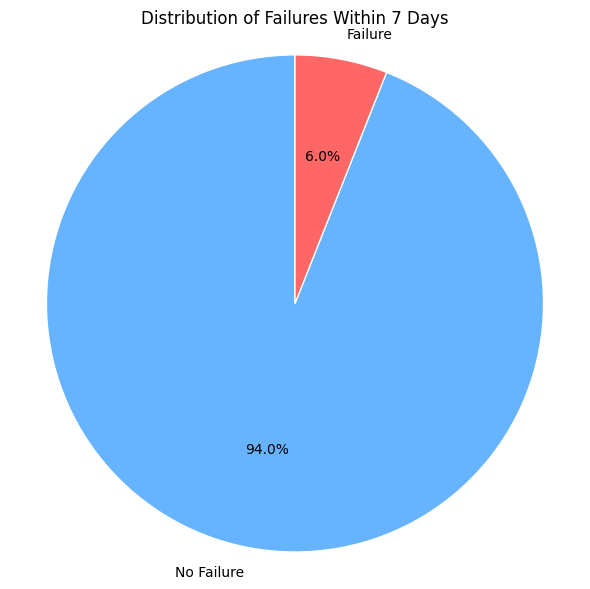

In [17]:
# Visualize class balance with a pie chart
labels = ["No Failure", "Failure"]
sizes = df["Failure_Within_7_Days"].value_counts()
colors = ["#66b3ff", "#ff6666"]

plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    colors=colors,
    startangle=90,
    wedgeprops={"edgecolor": "white"},
)
plt.title("Distribution of Failures Within 7 Days")
plt.axis("equal")
plt.tight_layout()
plt.show()

###### 🔹 &nbsp;&nbsp;&nbsp;&nbsp;*We want to reach a balance of 50/50 to ensure that our model will be trained with significant data*

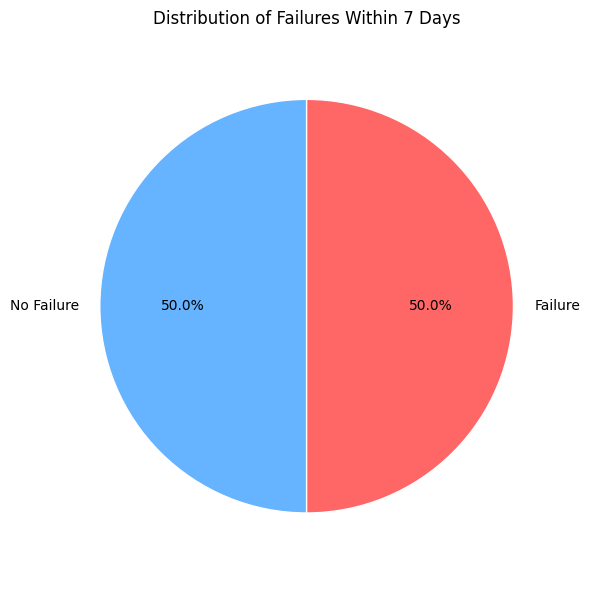

✅ Dataset balanced: Failure_Within_7_Days
1    30032
0    30032
Name: count, dtype: int64
📊 New shape: (60064, 18)


In [18]:
# Balance the dataset to achieve a 50/50 class distribution
count_true = df[df["Failure_Within_7_Days"] == True].shape[0]
count_false = df[df["Failure_Within_7_Days"] == False].shape[0]

# Undersample the majority class (False)
df_false_sampled = df[df["Failure_Within_7_Days"] == False].sample(
    count_true, random_state=42
)
df_true = df[df["Failure_Within_7_Days"] == True]

# Concatenate to get a balanced DataFrame
df = (
    pd.concat([df_false_sampled, df_true])
    .sample(frac=1, random_state=42)
    .reset_index(drop=True)
)

# Visualize class balance with a pie chart
labels = ["No Failure", "Failure"]
sizes = df["Failure_Within_7_Days"].value_counts()
colors = ["#66b3ff", "#ff6666"]

plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    colors=colors,
    startangle=90,
    wedgeprops={"edgecolor": "white"},
)
plt.title("Distribution of Failures Within 7 Days")
plt.axis("equal")
plt.tight_layout()
plt.show()

print(f"✅ Dataset balanced: {df['Failure_Within_7_Days'].value_counts()}")
print("📊 New shape:", df.shape)

#### 📊 Feature Distribution

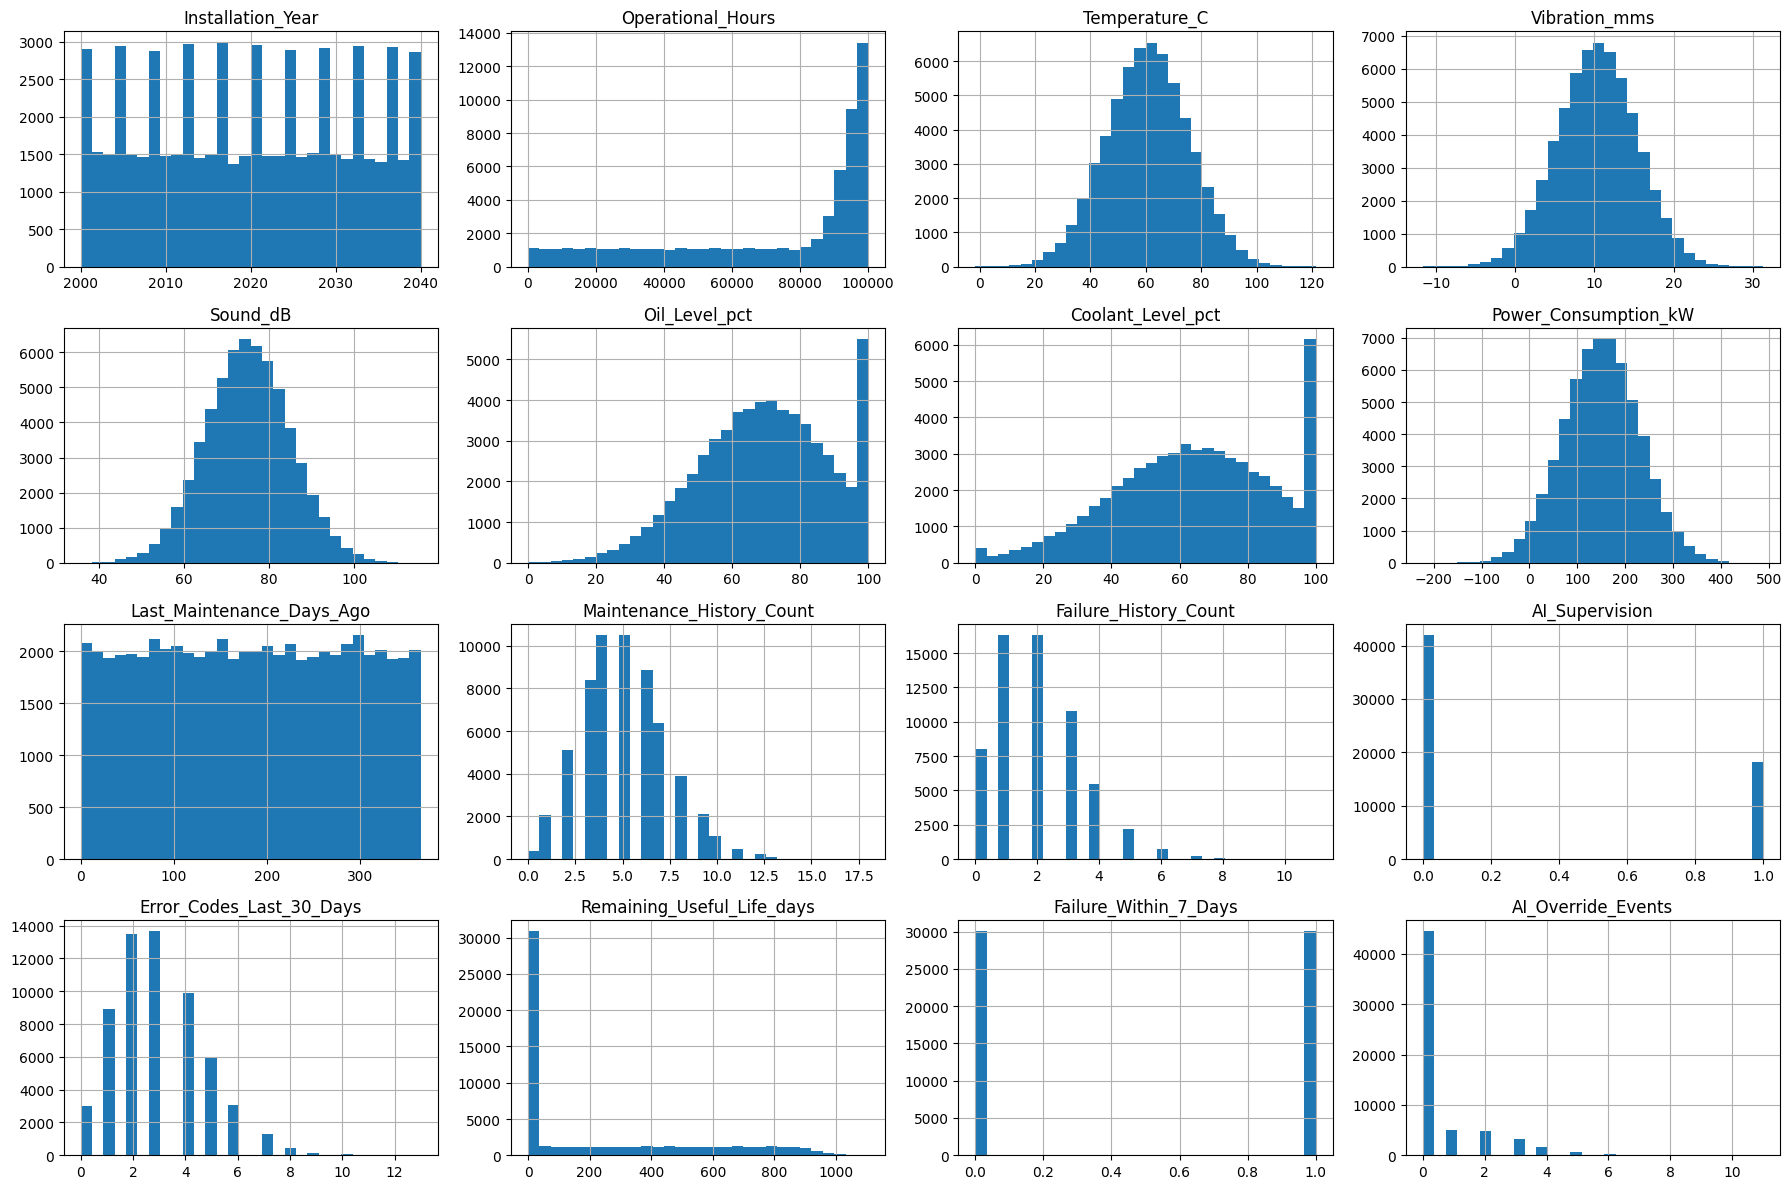

In [19]:
# Plot histograms for numeric features
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
df[numeric_cols].hist(bins=30, figsize=(18, 12))
plt.tight_layout()
plt.show()

#### 📈 Correlation Matrix

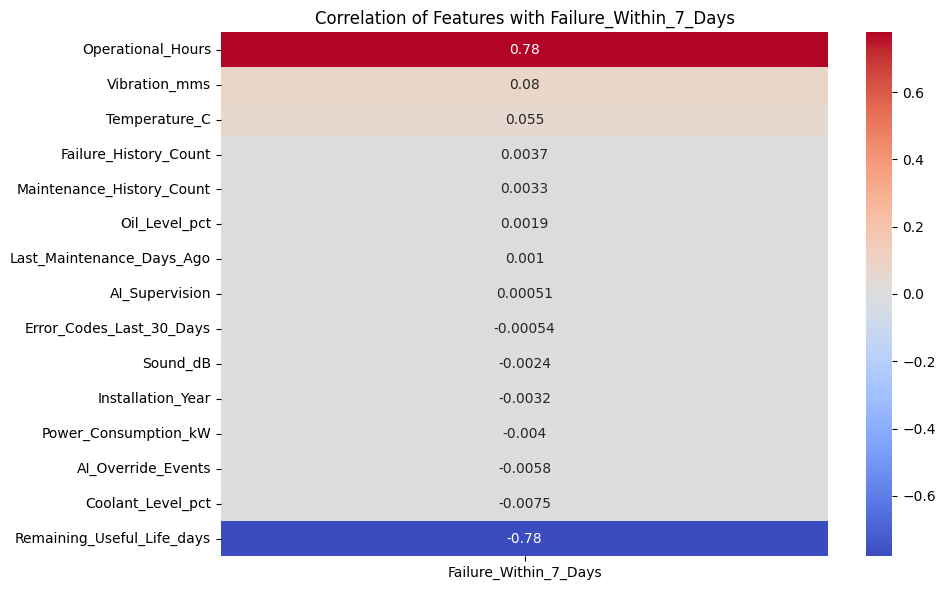

In [20]:
# Compute correlation matrix (numeric only)
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns.drop(
    "Failure_Within_7_Days", errors="ignore"
)
corr_matrix = df[numeric_cols.tolist() + ["Failure_Within_7_Days"]].corr()

# Get correlation of all features with the target
target_corr = corr_matrix["Failure_Within_7_Days"].drop("Failure_Within_7_Days")

# Plot sorted correlations
plt.figure(figsize=(10, 6))
sns.heatmap(
    target_corr.to_frame().sort_values(by="Failure_Within_7_Days", ascending=False),
    annot=True,
    cmap="coolwarm",
)
plt.title("Correlation of Features with Failure_Within_7_Days")
plt.tight_layout()
plt.show()

#### 🎯 Feature Selection thanks to feature coorelation and distribution

###### 🔹 &nbsp;&nbsp;&nbsp;&nbsp;*Remove feature with low variance*

In [21]:
from sklearn.feature_selection import VarianceThreshold

# Calculate variance for numeric columns
selector = VarianceThreshold(threshold=0.01)  # adjust if needed
selector.fit(df[numeric_cols])

# Keep only columns with sufficient variance
high_variance_cols = [
    col for col, keep in zip(numeric_cols, selector.get_support()) if keep
]

print("📌 Features retained based on variance threshold (0.01):")
for col in high_variance_cols:
    print(f" - {col}")

# Update dataframe to keep only high-variance features
df = df[high_variance_cols + ["Failure_Within_7_Days"]]

📌 Features retained based on variance threshold (0.01):
 - Installation_Year
 - Operational_Hours
 - Temperature_C
 - Vibration_mms
 - Sound_dB
 - Oil_Level_pct
 - Coolant_Level_pct
 - Power_Consumption_kW
 - Last_Maintenance_Days_Ago
 - Maintenance_History_Count
 - Failure_History_Count
 - AI_Supervision
 - Error_Codes_Last_30_Days
 - Remaining_Useful_Life_days
 - AI_Override_Events


###### 🔹 &nbsp;&nbsp;&nbsp;&nbsp;*Prevent Data Leakage: Remove Proxy Features*

In [22]:
# Exclude leakage-prone features
leakage_features = ["Remaining_Useful_Life_days"]
target_corr = target_corr.drop(labels=leakage_features, errors="ignore")

###### 🔹 &nbsp;&nbsp;&nbsp;&nbsp;*Select relevant features*

In [23]:
# Select features above correlation threshold
corr_threshold = 0.05
relevant_features = (
    target_corr[abs(target_corr) > corr_threshold]
    .sort_values(ascending=False)
    .index.tolist()
)

# Define features and target
features = relevant_features
X = df[features]
y = df["Failure_Within_7_Days"]

# Display selected features and their correlation
print("📌 Features selected based on correlation > 0.05:")
for feat in features:
    print(f" - {feat} (corr = {target_corr[feat]:.3f})")
print(f"\n✅ Total features selected: {len(features)}: {features}")

📌 Features selected based on correlation > 0.05:
 - Operational_Hours (corr = 0.778)
 - Vibration_mms (corr = 0.080)
 - Temperature_C (corr = 0.055)

✅ Total features selected: 3: ['Operational_Hours', 'Vibration_mms', 'Temperature_C']


#### ✂️ Data Split and Scaling

In [24]:
# Split and scale the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values)
X_test_scaled = scaler.transform(X_test.values)

####  🏋️ Model Training and Evaluation

#####  🔹 &nbsp;*We selected Logistic Regression and Random Forest Classifier for this binary classification task based on the following reasons:*

###### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- *Logistic Regression* is a simple, interpretable, and effective baseline model for binary classification. It allows us to understand the relationship between the input features and the target, and serves as a solid benchmark for performance comparison.

###### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- *Random Forest* is a powerful ensemble method that handles feature interactions, non-linear relationships, and imbalanced data well. It also provides insights into feature importance and tends to perform reliably across a wide range of datasets.


🎯 Training Random Forest...

              precision    recall  f1-score   support

           0       0.97      0.92      0.95      5945
           1       0.93      0.97      0.95      6068

    accuracy                           0.95     12013
   macro avg       0.95      0.95      0.95     12013
weighted avg       0.95      0.95      0.95     12013



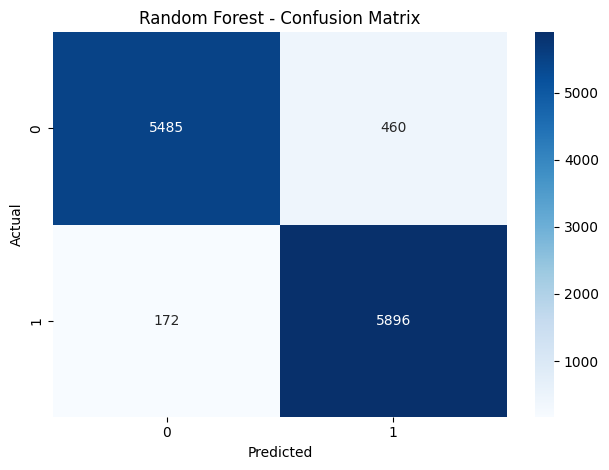

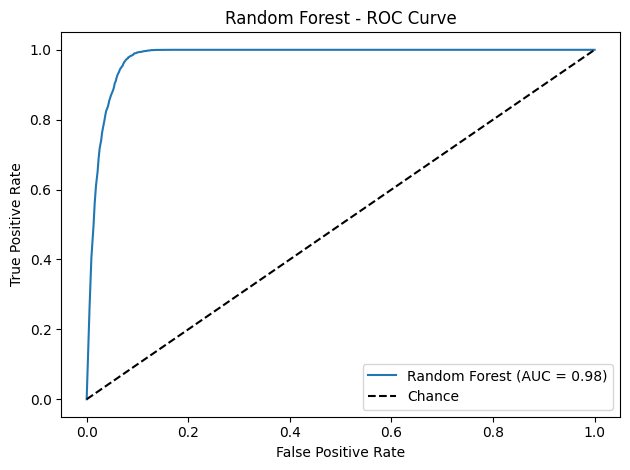


🎯 Training Logistic Regression...

              precision    recall  f1-score   support

           0       0.97      0.92      0.95      5945
           1       0.93      0.98      0.95      6068

    accuracy                           0.95     12013
   macro avg       0.95      0.95      0.95     12013
weighted avg       0.95      0.95      0.95     12013



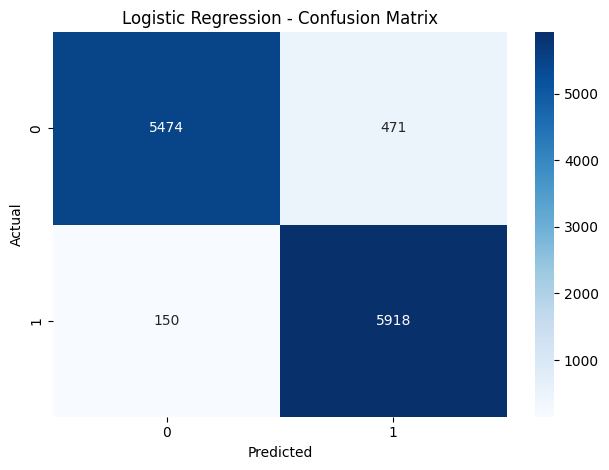

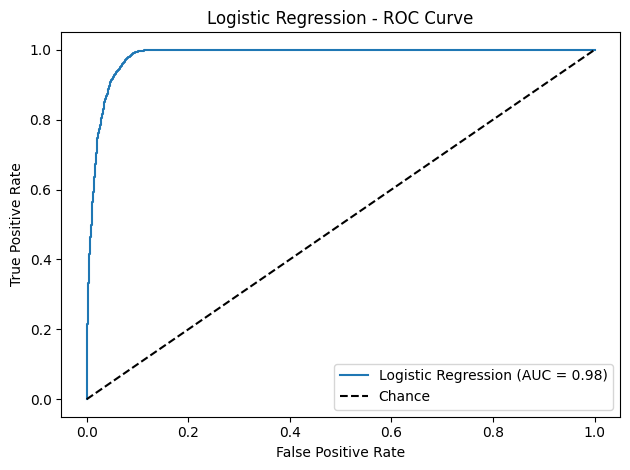

In [25]:
# Train and evaluate Random Forest and Logistic Regression
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
}

model_scores = {}

for name, model in models.items():
    print(f"\n🎯 Training {name}...\n")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Evaluation report
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # ROC AUC Curve
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    model_scores[name] = roc_auc  # Save AUC score

    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], "k--", label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name} - ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

####  🎚️Check threshold

In [26]:
best_model_name = max(model_scores, key=model_scores.get)
y_pred = (models[best_model_name].predict_proba(X_test_scaled)[:, 1] > 0.6).astype(int)
print(f"✅ Predictions with threshold 0.6:\n{y_pred}")

✅ Predictions with threshold 0.6:
[1 1 0 ... 0 0 1]


####  💾 Save Best Model and its scaler

In [27]:
# Create models/ directory if it doesn't exist
os.makedirs("../models", exist_ok=True)

# Select best model based on AUC score
best_model = models[best_model_name]

# Save the trained model
model_path = (
    f'../models/failure_predictor_{best_model_name.replace(" ", "_").lower()}.pkl'
)
joblib.dump(best_model, model_path)
print(f"✅ Best model ({best_model_name}) saved to: {model_path}")

# Save the fitted scaler as well
scaler_path = "../models/scaler.pkl"
joblib.dump(scaler, scaler_path)
print(f"✅ Scaler saved to: {scaler_path}")

✅ Best model (Logistic Regression) saved to: ../models/failure_predictor_logistic_regression.pkl
✅ Scaler saved to: ../models/scaler.pkl
